In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import pandas as pd
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    IntegerParameter,
    HyperparameterTuner,
)

from src import fetch_bucketed_from_bitmex, preprocess, evaluate, train_linear, train_lstm

input_dir = 'cache_input'
model_dir = 'cache_model'
output_dir = 'cache_output'
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# Crawling the Dataset

In [2]:
df = fetch_bucketed_from_bitmex('XBTZ19', '1m')

# Feature Engineering

In [4]:
preprocess(df, input_dir)

In [ ]:
pd.read_csv('cache_input/trai_x.csv', index_col="timestamp", parse_dates=True).describe()

,vwap_log_diff,high_log_diff,low_log_diff,close_log_diff,trades_log,home_notional_log,foreign_notional_log,macd_12_26,macd_sign_12_26,macd_diff_12_26,rsi_14
count,1.694470e+05,169447.000000,169447.000000,169447.000000,169447.000000,169447.000000,169447.000000,169447.000000,169447.000000,169447.000000,169447.000000
mean,2.103270e-07,0.000331,-0.000405,-0.000030,2.327623,0.904010,8.001527,0.016810,0.016957,-0.000147,0.493503
std,1.110140e-03,0.001197,0.001344,0.001379,1.355381,0.942349,3.604371,15.529616,14.601622,4.729597,0.243416
min,-8.016040e-02,-0.010535,-0.134631,-0.057718,0.000000,0.000000,0.000000,-529.443354,-406.934174,-232.321787,0.000121
25%,-2.452545e-04,-0.000096,-0.000588,-0.000416,1.386294,0.092285,6.908755,-4.504296,-4.247664,-1.572127,0.301271
50%,0.000000e+00,0.000034,-0.000066,-0.000003,2.397895,0.625691,9.116469,-0.015389,-0.016169,-0.027213,0.490214
75%,2.470071e-04,0.000506,0.000048,0.000338,3.295837,1.468111,10.466953,4.984849,4.703573,1.523237,0.684432
max,2.544539e-02,0.068130,0.014770,0.047410,7.013915,6.998430,16.050549,224.120051,200.977545,104.473570,0.999664


# Training

### Benchmark: Linear Model

In [14]:
train_linear(
    input_dir=input_dir,
    output_dir=output_dir,
    model_dir=model_dir,
    hidden_dim=64,
    lr=1e-3,
    batch_size=1024,
    n_epochs=16,
)

Using device cpu.
| epoch | trai loss | vali loss | time/s |
| ----: | --------- | --------- | -----: |
|     0 | 3.744e-03 | 3.416e-04 |      0 |
|     1 | 2.276e-04 | 8.824e-05 |      0 |
|     2 | 7.834e-05 | 3.242e-05 |      1 |
|     3 | 4.416e-05 | 2.008e-05 |      0 |
|     4 | 3.458e-05 | 1.919e-05 |      0 |
|     5 | 3.327e-05 | 1.861e-05 |      0 |
|     6 | 3.208e-05 | 1.800e-05 |      0 |
|     7 | 3.090e-05 | 1.736e-05 |      0 |
|     8 | 3.042e-05 | 1.732e-05 |      0 |
|     9 | 2.994e-05 | 1.738e-05 |      0 |
|    10 | 2.976e-05 | 1.736e-05 |      0 |
|    11 | 2.959e-05 | 1.729e-05 |      0 |
|    12 | 2.949e-05 | 1.729e-05 |      0 |
|    13 | 2.945e-05 | 1.729e-05 |      0 |
|    14 | 2.943e-05 | 1.729e-05 |      0 |
|    15 | 2.941e-05 | 1.728e-05 |      0 |
loss of trai is 2.939e-05
loss of vali is 1.728e-05
loss of test is 1.367e-05


### Solution: LSTM Model

In [2]:
# inputs = sagemaker_session.upload_data(
#     path=input_dir, bucket=bucket, key_prefix="lstm-trader"
# )

# estimator = PyTorch(
#     source_dir="src",
#     entry_point="trainer_lstm.py",
#     hyperparameters={"lstm-layers": 2, "lr": 1e-3, "batch-size": 1024, "n-epochs": 16,},
#     framework_version="1.2.0",
#     role=role,
#     sagemaker_session=sagemaker_session,
#     train_instance_count=1,
#     train_instance_type="ml.p2.xlarge",
# )

# tuner = HyperparameterTuner(
#     estimator,
#     objective_metric_name="test loss",
#     hyperparameter_ranges={
#         "hidden-dim": IntegerParameter(128, 256),
#         "dropout": ContinuousParameter(0.1, 0.9),
#     },
#     metric_definitions=[
#         {
#             "Name": "test loss",
#             "Regex": "loss of test is ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+))",
#         }
#     ],
#     max_jobs=32,
#     max_parallel_jobs=4,
#     objective_type="Minimize",
# )

# tuner.fit({"data_dir": inputs})

In [ ]:
# train_lstm(
#     input_dir=input_dir,
#     output_dir=output_dir,
#     model_dir=model_dir,
#     hidden_dim=64,
#     lstm_layers=2,
#     dropout=0.1,
#     lr=1e-3,
#     batch_size=1024,
#     n_epochs=4,
# )

inputs = sagemaker_session.upload_data(
    path=input_dir, bucket=bucket, key_prefix="lstm-trader"
)

estimator = PyTorch(
    source_dir="src",
    entry_point="trainer_lstm.py",
    hyperparameters={
        "hidden-dim": 128,
        "lstm-layers": 2,
        "dropout": 0.1,
        "lr": 1e-3,
        "batch-size": 1024,
        "n-epochs": 16,
    },
    framework_version="1.2.0",
    role=role,
    sagemaker_session=sagemaker_session,
    train_instance_count=1,
    train_instance_type="ml.p2.xlarge",
)

estimator.fit({"data_dir": inputs})

2020-01-10 17:07:48 Starting - Starting the training job...
2020-01-10 17:07:50 Starting - Launching requested ML instances......
2020-01-10 17:08:54 Starting - Preparing the instances for training......
2020-01-10 17:10:10 Downloading - Downloading input data......
2020-01-10 17:11:11 Training - Downloading the training image............
2020-01-10 17:13:11 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-10 17:13:12,546 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-10 17:13:12,571 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-10 17:13:15,595 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-10 17:13:15,855 sagemaker-containers INFO     Module trainer_lstm does not provide a setup.py. 
Generating setup.py
2020-01-10 1

In [ ]:
sagemaker_session.download_data(
    path=output_dir,
    bucket=bucket,
    key_prefix=estimator.latest_training_job.name + "/output/output.tar.gz",
)
!tar xvf cache_output/output.tar.gz --directory=cache_output

pred_trai_lstm.csv
loss_trai_lstm.csv
pred_vali_lstm.csv
pred_test_lstm.csv
loss_vali_lstm.csv
loss_test_lstm.csv


# Evaluation

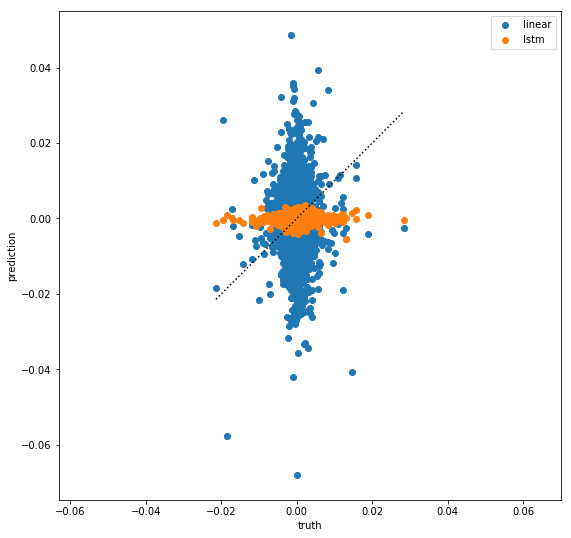

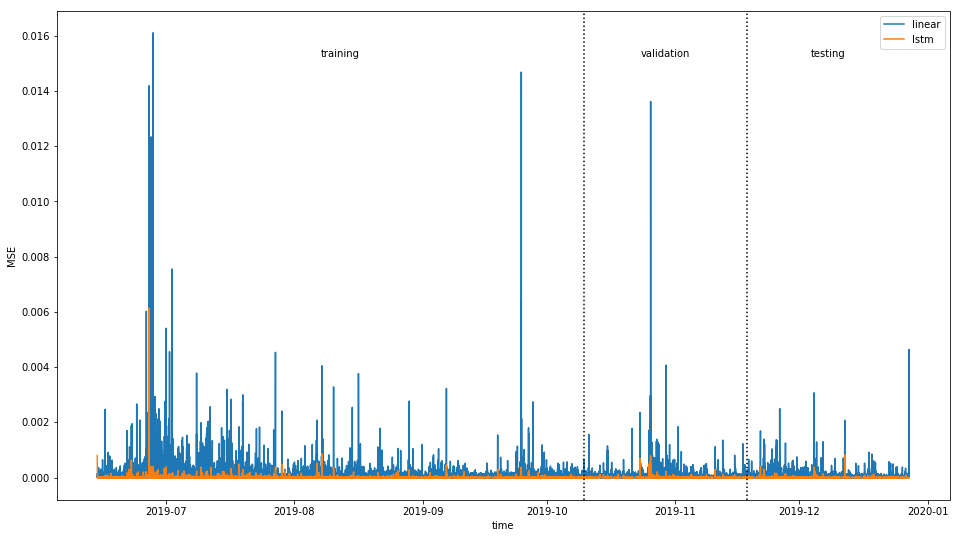

In [4]:
evaluate(input_dir, output_dir)